# Stability of least squares algorithms

We're going to explore several alternatives for least squares by means of the following fitting problem:

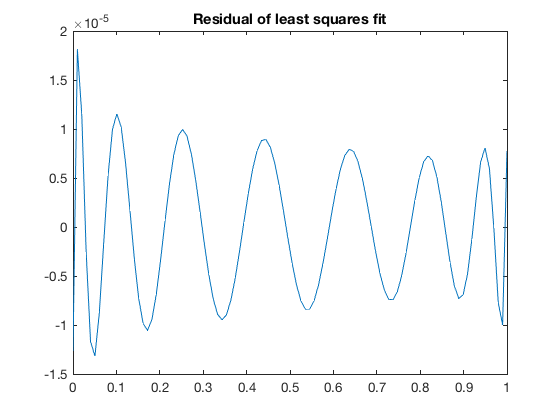

In [1]:
m = 100; n = 15;
t = (0:m-1)'/(m-1);
A = t.^(0:n-1);
b = exp(sin(4*t));
x = A\b;

plot(t,b-A*x)
title("Residual of least squares fit");

You can see that the fit is quite good. As in the text, we will renormalize the vector $b$ to make the last coefficient of the solution equal to 1.

In [2]:
b = b/2006.787453104852;
x = A\b;  y = A*x;

As in the text, we compute all the numbers associated with the conditioning of the least squares problem, as described by Theorem 18.1. Since the residual is small, the conditioning of $x$ will be close to $\kappa(A)$.

In [3]:
kappa = cond(A)
theta = asin(norm(y-b)/norm(b))
eta = norm(A)*norm(x)/norm(y)


kappa =

   2.2718e+10


theta =

   3.7461e-06


eta =

   2.1036e+05



In [5]:
K = zeros(2,2);
K(1,1) = sec(theta);  K(2,1) = kappa*K(1,1);
K(1,2) = K(2,1)/eta;  K(2,2) = kappa + kappa^2*tan(theta)/eta;
format short e, K


K =

   1.0000e+00   1.0800e+05
   2.2718e+10   3.1909e+10



## Backslash

The internal backslash does Householder QR, including an extra column swapping ability to improve accuracy in some situations. Here's how it does.

In [6]:
x = A\b;
format long, x(n)
errBS = abs(x(n)-1)


ans =

   1.000000080839684


errBS =

     8.083968383587603e-08



We've lost about 9 digits of accuracy, which is in line with the conditioning of $x$ with respect to $A$ (the (2,2) element of $K$ above). 

## Householder QR solution

With a default call to `qr`, column pivoting is not used.

In [7]:
[Q,R] = qr(A,0);
x = R\(Q'*b);
x(n)
errHH = abs(x(n)-1)


ans =

   1.000000133092542


errHH =

     1.330925420983675e-07



## Modified GS QR solution

Classical Gram-Schmidt is too unstable even to bother with. The modified form is better, but problems remain:

In [8]:
[Q,R] = mgs(A);
x = R\(Q'*b);
x(n)
errMGS = abs(x(n)-1)


ans =

   0.981684027601993


errMGS =

   0.018315972398007



Crikey! That's much worse than is accounted for by the problem conditioning. The culprit is our nonorthogonal $Q$.

In [9]:
norm(Q'*Q-eye(n))


ans =

     2.137938905971698e-07



There's a simple workaround. We can imitate Gaussian elimination and factor an "augmented matrix" in order to get an implicit-Q result. 

In [10]:
[Q,R] = mgs([A b]);
x = R(:,1:n) \ R(:,n+1);
x(n)
errMGS = abs(x(n)-1)


ans =

   0.999999998077498


errMGS =

     1.922502268492110e-09



On my machine, this is the best solution yet!

## Normal equations

This problem is a perfect storm for the normal equations: a very good fit (small residual) and a badly conditioned matrix. Squaring that condition number is catastrophic.

In [11]:
x = (A'*A)\(A'*b);
x(n)



ans =

  -0.094027703104668



## SVD

The SVD is considered the gold standard of stability in least squares. It is preferred to QR when the matrix is nearly or numerically rank deficient.

In [13]:
[U,S,V] = svd(A,0);
x = V*((U'*b)./diag(S));
x(n)
errSVD = abs(x(n)-1)


ans =

   1.000000133090634


errSVD =

     1.330906336249882e-07

